<a href="https://colab.research.google.com/github/MorganBaccus/CptS-437/blob/main/Baccus_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment #1**

Assigned: January 20, 2021

Due: February 1, 2021



---

This assignment consists of four questions that require a short answer and one that requires you to generate some Python code. You can enter your answers and your code directly in a Colaboratory notebook and upload the **shareable** link for your notebook as your homework submission.


---

#1.

(20 points) Use information gain to build a decision tree that predicts the value of the class $Play$ based on the input features $Ace$, $Ten$, and $FirstMove$, using the training data provided below. Show each step of your calculations.

Ace | Ten | FirstMove | Play
--- | --- | --- | ---
false | false | false | stand
true | false | true | hit
true | true | false | hit
true | true | true | stand

Is this tree optimal? In other words, does it yield zero classification error on the training data with minimal depth? Explain why or why not. If it is not optimal, draw the optimal tree as well. You can either include the tree(s) as a picture or describe using text.

Answer:

![](https://drive.google.com/uc?id=1_G8HJ7Eil5qXSRaOfaON2LCnTDS_dG-h)
![](https://drive.google.com/uc?id=1vp_JVb3dHy8TnUBl0SnVQOAP3SSId1r7)
![](https://drive.google.com/uc?id=1wzPbmG7P7I7NTbH3380SLLRWkI1VoJNU)

---


#2.

(10 points) Express the concept (Play=Hit) learned by all of your trees in Problem 1 as logical if-then rules.

Answer:

Original tree:

Play=Hit: (Ace= True and Ten=False) or (Ace=True and Ten=True and FirstMove=False)

Optimal Tree:

Play=Hit: (Ten=False and FirstMove=True) or (Ten=True and FirstMove=False)

---

#3.

(10 points) The decision tree algorithm we discussed in class is a greedy algorithm. What does this
mean? What is the reason that most decision tree learning algorithms are greedy?

Answer:

Greedy algorithms make decisions that are optimal at each local decision point. Greedy algorithms only consider the optimal decision at the current point rather than if it is a globally-optimal decision. For example, in problem one the greedy decision put Ace as the root node. However, the globally-optimal solution was to have Ten as the root node since that produced a smaller tree. The reason that greedy algorithms are used more often is that there are fewer computations required to solve for the tree and are thus easier to implement on large data sets. The number of calculations that a globally-optimal tree requires are exponential to the size of the problem, while greedy algorithms only require calculations equal to a polynomial function using the number of data entries and features.

---

#4.

(10 points) Suppose you are testing a new algorithm on a data set consisting of 100 positive and 100 negative examples. You plan to use leave-one-out cross-validation and compare your algorithm to a baseline function, a simple majority classifier. With leave-one-out cross-validation, you train the algorithm on 199 data points and test it on 1 data point. You repeat the process 400 times, letting each point having a chance to represent the test set, and report the average of the classification accuracies. Given a set of training data, the majority classifier always outputs the class that is in the majority in the training set, regardless of the input. You expect the majority classifier to achieve about 50% classification accuracy, but to your surprise, it scores zero every time. Why?

Answer:

When you remove an example from the test data, the other class will become the majority and thus be the predicted result. For example, if a negative value is removed then there will now be 99 negative examples and 100 postives examples. Negative will be the minority class and positive will be the majority class. The majority classifier will then predict that the removed example is positive when it was not.

---



#5.

(75 points) In this problem you are asked to write a Python program using Google Colab. We provide code below to construct a decision tree using the measures of entropy and gain discussed in class. You need to enhance this program in three ways.

- First, note that the provided code assumes that the features are all discrete (there is a finite number of possible feature values) and not continuous. Modify the code to handle either discrete or continuous-valued features. In this case, we ask that you convert continuous-valued features to discrete features using equal-frequency binning, where the number of bins can be a parameter or hard-coded.

- Second, use the dataset found at http://eecs.wsu.edu/~cook/ml/alldata.csv to test your model. This a comma-separated data file, one line per data point. The last entry on each line is the class value and the remaining entries represent the feature values. This data is a ``human activity recognition using smartphones'' dataset. The features represent statistical summaries of sensor data collected with a phone-based 3D accelerometer (measuring phone acceleration in X, Y, and Z directions) and a 3D gyroscope (measuring 3-axial angular velocity). The phone was worn by participants while they performed two activities: sit (-1) and stand (1). You will need to read in the dataset and store the data in a structure that the program can process. To test the model, randomly select a subset of points for training the model and randomly select a second subset of points for testing the model. For now, do not worry about whether the subsets overlap or not (in the future, not overlapping will be an important issue).

- Third, generate a learning curve to show how the model performs on the data. You can use functions available from the matplotlib library (https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.plot.html) to generate the plot. The y axis of the plot should be classification accuracy, tested on a randomly-selected subset of 100 instances. The x axis of the plot should be the number of instances that was used for training. Create a minimum of 10 points for your learning curve plot with a broad range of x values (you can add more than 10 points to make the curve more complete).

Finally, you may notice that the curve jumps around quite a bit. Smooth the curve by repeating the process at least 10 times and plotting the average of the results over the 10 trials.

What insights does the learning curve provide on the learning process and the need for a large amount of training data?

*Note that all of the code you write needs to be entirely your own, not copied from another existing program or using existing libraries that perform the specified functionality.*

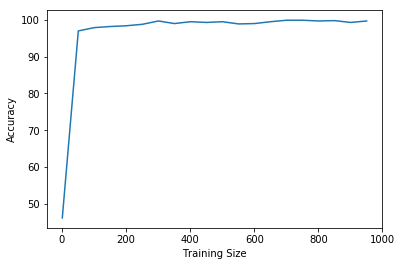

In [ ]:
# Decision tree learning
#
# Assumes discrete features. Examples may be inconsistent. Stopping condition for tree
# generation is when all examples have the same class, or there are no more features
# to split on (in which case, use the majority class). If a split yields no examples
# for a particular feature value, then the classification is based on the parent's
# majority class.


import math
import copy
import numpy as np
import collections
import random
from random import sample
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

class TreeNode:
    def __init__(self, majClass):
        self.split_feature = -1 # -1 indicates leaf node
        self.children = {} # dictionary of {feature_value: child_tree_node}
        self.majority_class = majClass
        
def build_tree(examples):
    if not examples:
        return None
    # collect sets of values for each feature index, based on the examples
    features = {}
    for feature_index in range(len(examples[0]) - 1):
        features[feature_index] = set([example[feature_index] for example in examples])
    return build_tree_1(examples, features)
    
def build_tree_1(examples, features):
    tree_node = TreeNode(majority_class(examples))
    # if examples all have same class, then return leaf node predicting this class
    if same_class(examples):
        return tree_node
    # if no more features to split on, then return leaf node predicting majority class
    if not features:
        return tree_node
    # split on best feature and recursively generate children
    best_feature_index = best_feature(features, examples)
    tree_node.split_feature = best_feature_index
    remaining_features = features.copy()
    remaining_features.pop(best_feature_index)
    for feature_value in features[best_feature_index]:
        split_examples = filter_examples(examples, best_feature_index, feature_value)
        tree_node.children[feature_value] = build_tree_1(split_examples, remaining_features)
    return tree_node

def majority_class(examples):
    classes = [example[-1] for example in examples]
    return max(set(classes), key = classes.count)

def same_class(examples):
    classes = [example[-1] for example in examples]
    return (len(set(classes)) == 1)

def best_feature(features, examples):
    # Return index of feature with lowest entropy after split
    best_feature_index = -1
    best_entropy = 2.0 # max entropy = 1.0
    for feature_index in features:
        se = split_entropy(feature_index, features, examples)
        if se < best_entropy:
            best_entropy = se
            best_feature_index = feature_index
    return best_feature_index

def split_entropy(feature_index, features, examples):
    # Return weighted sum of entropy of each subset of examples by feature value.
    se = 0.0
    for feature_value in features[feature_index]:
        split_examples = filter_examples(examples, feature_index, feature_value)
        se += (float(len(split_examples)) / float(len(examples))) * entropy(split_examples)
    return se

def entropy(examples):
    classes = [example[-1] for example in examples]
    classes_set = set(classes)
    class_counts = [classes.count(c) for c in classes_set]
    e = 0.0
    class_sum = sum(class_counts)
    for class_count in class_counts:
        if class_count > 0:
            class_frac = float(class_count) / float(class_sum)
            e += (-1.0)* class_frac * math.log(class_frac, 2.0)
    return e

def filter_examples(examples, feature_index, feature_value):
    # Return subset of examples with given value for given feature index.
    return list(filter(lambda example: example[feature_index] == feature_value, examples))

def print_tree(tree_node, feature_names, depth = 1):
    indent_space = depth * "  "
    if tree_node.split_feature == -1: # leaf node
        print(indent_space + feature_names[-1] + ": " + tree_node.majority_class)
    else:
        for feature_value in tree_node.children:
            print(indent_space + feature_names[tree_node.split_feature] + " == " + feature_value)
            child_node = tree_node.children[feature_value]
            if child_node:
                print_tree(child_node, feature_names, depth+1)
            else:
                # no child node for this value, so use majority class of parent (tree_node)
                print(indent_space + "  " + feature_names[-1] + ": " + tree_node.majority_class)

def classify(tree_node, instance):
    if tree_node.split_feature == -1:
        return tree_node.majority_class
    child_node = tree_node.children[instance[tree_node.split_feature]]
    if child_node:
        return classify(child_node, instance)
    else:
        return tree_node.majority_class

def makeDiscrete(data):
  midPoint = len(data) / 2
  sortedValues = copy.copy(data) # create a copy of the data to sort
  sortedValues.sort()
  threshold = sortedValues[int(midPoint)]

  binnedData = np.zeros(len(data), dtype=int)

  for i in range(len(data)): # iterate through data and bin based on if value is > or <= threshold
    if (data[i] <= threshold):
      binnedData[i]=0 # assign 0 if value is <= threshold
    else:
        binnedData[i]=1 # assign 1 if value is > threshold
  return binnedData

def plotGraph(x, y):
  fig, ax = plt.subplots()
  ax.plot(x, y)
  ax.set(xlabel='Training Size', ylabel='Accuracy')
  plt.show()

if __name__ == "__main__":
   random.seed()
   dataFrame = pd.read_csv('https://eecs.wsu.edu/~cook/ml/alldata.csv')
   data = dataFrame.to_numpy()

   if True: # check that the data is continuous
      examples = np.zeros(np.shape(data), dtype=str)
      for i in range(len(data[0])-1):
         examples[:,i] = makeDiscrete(data[:,i])
   else:
      examples = data

   for i in range(len(data)):
     examples[i][len(data[0])-1] = str(data[i][len(data[0])-1])
   
   sampleData = []
   output = []
   numberOfTrials = 10

   for trials in range(numberOfTrials):
      count = 0

      for i in range(1, 1000, 50):
         testSet = sample(examples, 100)
         trainSet = sample(examples, i)
         tree = build_tree(trainSet)
         right = 0

         for j in range(100):
            testClass = classify(tree, testSet[j])
            if testClass == testSet[j][len(data[0])-1]:
               right += 1
         if trials == 0:
            sampleData.append(i)
            output.append(right)
         else:
            output[count] += right
         count += 1

   for i in range(len(output)):
      output[i] = output[i] / float(numberOfTrials)
      
   plotGraph(sampleData, output)

If there are too few data points then there is a risk of underfitting the graph. However, if there is too much training data then there is a risk of overfitting the graph.